# Importacion de librerias

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import pathlib
import random
import IPython.display as display
from random import randint


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Configuraciones de TensorFlow

In [2]:
#Definimos esta variable para no usar la GPU si llega a estar ocupada
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
tf.enable_eager_execution()

In [4]:
#Comprobar que estoy ejecutandome en modo eagerly
tf.executing_eagerly()

True

In [5]:
#Log device placement corresponde a si yo quiero ver la informacion en donde se mapea o guardan las variables que creo
config = tf.ConfigProto(log_device_placement=True)

# Carga de Datos

### Como construir tu propio dataset

In [6]:
!cd ../DataSets/UCF101 

In [7]:
root_path = pathlib.Path("../DataSets/UCF101")
root_path

PosixPath('../DataSets/UCF101')

In [9]:
for folder in root_path.iterdir():
    print(folder)

../DataSets/UCF101/flow
../DataSets/UCF101/frames


In [21]:
videos_rgb_path = list(root_path.glob('frames/*'))
videos_rgb_path = [str(video) for video in videos_rgb_path]
len(videos_rgb_path)

13320

In [22]:
videos_rgb_path[:10]

['../DataSets/UCF101/frames/v_PlayingPiano_g24_c04',
 '../DataSets/UCF101/frames/v_RopeClimbing_g20_c02',
 '../DataSets/UCF101/frames/v_BlowingCandles_g18_c01',
 '../DataSets/UCF101/frames/v_Rowing_g05_c04',
 '../DataSets/UCF101/frames/v_Archery_g23_c07',
 '../DataSets/UCF101/frames/v_HeadMassage_g16_c04',
 '../DataSets/UCF101/frames/v_JumpingJack_g07_c04',
 '../DataSets/UCF101/frames/v_Shotput_g08_c07',
 '../DataSets/UCF101/frames/v_Skiing_g16_c04',
 '../DataSets/UCF101/frames/v_PlayingCello_g09_c05']

In [23]:
video_path = pathlib.Path(random.choice(videos_rgb_path))
frames_path = list(video_path.glob('*'))
frames_path = [str(frame_path) for frame_path in frames_path]
print(video_path)

../DataSets/UCF101/frames/v_PushUps_g10_c03


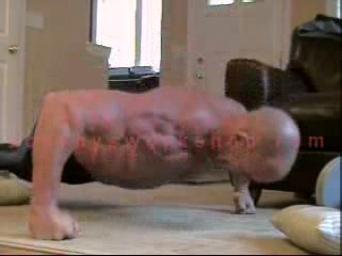

In [24]:
display.display(display.Image(random.choice(frames_path)))

In [14]:
nombres_clases = sorted(item.name for item in videos_rgb_path if item.is_dir())
nombres_clases = [clase.split("_")[1] for clase in nombres_clases]

#Extraccion de todos los tipos de clases en un vector de python
clases = []
for clase in nombres_clases:
    if clase not in clases:
        clases.append(clase)

#label_names, __ = tf.unique(label_names)
nombres_clases = clases
nombres_clases[:10]

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [15]:
clase_a_numero = dict((name, index) for index,name in enumerate(nombres_clases))
len(clase_a_numero)

101

In [16]:
clases_videos = [clase_a_numero[item.name.split("_")[1]] for item in videos_rgb_path]
clases_videos[:10]

[63, 74, 13, 75, 2, 38, 47, 78, 80, 58]

### Como cargar los videos usando la libreria de tensorflow

In [17]:
def seleccionar_cuadro_aleatorio(imagen, nueva_dimension):
    pos_y = randint(0,imagen.shape[0].value - nueva_dimension)
    pos_x = randint(0,imagen.shape[1].value - nueva_dimension)
    return imagen[pos_y : pos_y + nueva_dimension , pos_x : pos_x + nueva_dimension, :]

In [18]:
def seleccionar_extension_temporal(video, nro_frames):
    extension = randint(0,video.shape[0].value - nro_frames)
    return video[extension : extension + nro_frames, : , :, :]

In [ ]:
#Funcion sin ser usada aun
def procesar_frame(frame_path):
    frame_raw = tf.io.read_file(str(frame_path))
    frame_tensor = tf.image.decode_image(frame_raw, channels=3)
    frame_tensor = tf.image.resize(frame_tensor,[128,171])
    return frame_tensor

In [25]:
def cargar_preprocesar_video(video_path):
    video = []
    for frame_path in sorted(list(pathlib.Path(video_path).glob('*'))):
        frame_raw = tf.io.read_file(str(frame_path))
        frame_tensor = tf.image.decode_image(frame_raw, channels=3)
        frame_tensor = tf.image.resize(frame_tensor,[128,171])
        frame_tensor = seleccionar_cuadro_aleatorio(frame_tensor, 112)
        video.append(frame_tensor)
    video = tf.convert_to_tensor(video)
    video = seleccionar_extension_temporal(video, 16)
    return video

In [ ]:
#Forma de cargar los videos para usarlos como dataset pero ocupa mucha memoria, entonces se va hacer buffering con tensor
videos = []
for video_path in videos_rgb_path:
    video = []
    for frame_path in sorted(list(video_path.glob('*'))):
        frame_raw = tf.io.read_file(str(frame_path))
        frame_tensor = tf.image.decode_image(frame_raw, channels=3)
        frame_tensor = tf.image.resize(frame_tensor,[128,171])
        frame_tensor = seleccionar_cuadro_aleatorio(frame_tensor, 112)
        video.append(frame_tensor)
    video = tf.convert_to_tensor(video)
    video = seleccionar_extension_temporal(video, 16)
    videos.append(video)
videos = tf.convert_to_tensor(videos)

In [ ]:
video = []
for frame_path in sorted(list(video_path.glob('*'))):
    frame_raw = tf.io.read_file(str(frame_path))
    frame_tensor = tf.image.decode_image(frame_raw, channels=3)
    frame_tensor = tf.image.resize(frame_tensor,[128,171])
    video.append(frame_tensor)
video = tf.convert_to_tensor(video)

In [26]:
#Construccion del dataset a partir de los path y cargar los datos usando prefetch
videos_rgb_path_ds = tf.data.Dataset.from_tensor_slices(videos_rgb_path)

In [27]:
videos_rgb_path_ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [29]:
videos_ds = videos_rgb_path_ds.map(cargar_preprocesar_video, num_parallel_calls=tf.data.experimental.AUTOTUNE)

TypeError: argument should be a path or str object, not <class 'tensorflow.python.framework.ops.Tensor'>

In [34]:
for element in videos_rgb_path_ds.take(1):
    tf.print(element)

# Red Neuronal